In [225]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import json

In [226]:
df = pd.read_csv('training_data.csv')
df['YearMonth'] = pd.to_datetime(df['YearMonth'])

In [227]:
# project feature values
def project_feature_values(data, steps):
    x = np.arange(len(data))
    y = data.values
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    future_values = m * (np.arange(len(data), len(data) + steps)) + c
    return future_values

In [228]:
# Select features
def select_features(X, y, k=10):
    if len(X) <= k:
        return X.columns.tolist()  
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores.head(k).index.tolist()

In [229]:
def prepare_data_for_prophet(df, zipcode):
    zipcode_data = df[df['zipcode'] == zipcode].sort_values('YearMonth')
    if len(zipcode_data) < 24: # check data
        return None, None
    
    prophet_df = zipcode_data[['YearMonth', 'AveragePrice']].rename(columns={'YearMonth': 'ds', 'AveragePrice': 'y'})
    
    additional_features = ['ArrestCount', 'NoiseComplaints', 'distance_to_facility',
                           'cultural_facility', 'education_facility', 'health_services',
                           'public_safety', 'recreational_facility', 'religious_institution',
                           'transportation_facility', 'population', 'average_household_income']
    
    X = zipcode_data[additional_features]
    y = zipcode_data['AveragePrice']
    
    selected_features = select_features(X, y)
    
    for feature in selected_features:
        prophet_df[feature] = zipcode_data[feature]
    
    return prophet_df, selected_features

In [230]:
def fit_and_predict_prophet(data, selected_features, steps=60):
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
    
    for feature in selected_features:
        model.add_regressor(feature)
    
    model.fit(data)
    
    future = model.make_future_dataframe(periods=steps, freq='M')
    
    for feature in selected_features:
        future[feature] = np.concatenate([data[feature], project_feature_values(data[feature], steps)])
    
    forecast = model.predict(future)
    
    if forecast['yhat'].iloc[0] < data['y'].iloc[-1] * 0.9:
        print("Warning: Significant drop detected at the start of the forecast.")
    
    return forecast, model


In [231]:
def calculate_roi(initial_price, final_price):
    return (final_price - initial_price) / initial_price

In [241]:
def get_zipcode_scores(df, zipcode, years=[1, 3, 5]):
    zipcode_data, selected_features = prepare_data_for_prophet(df, zipcode)
    if zipcode_data is None:
        return None
    
    current_price = zipcode_data['y'].iloc[-1]
    forecast, _ = fit_and_predict_prophet(zipcode_data, selected_features)
    
    last_date = zipcode_data['ds'].iloc[-1]
    
    roi_results = {}
    for year in years:
        forecast_date = last_date + pd.DateOffset(years=year)
        forecast_index = (forecast['ds'] - forecast_date).abs().argsort()[0]
        
        future_price = forecast['yhat'].iloc[forecast_index]
        roi = calculate_roi(current_price, future_price)
        roi_lower = calculate_roi(current_price, forecast['yhat_lower'].iloc[forecast_index])
        roi_upper = calculate_roi(current_price, forecast['yhat_upper'].iloc[forecast_index])
        
        roi_results[f'{year}Yr_ROI'] = roi
        roi_results[f'{year}Yr_ROI_Lower'] = roi_lower
        roi_results[f'{year}Yr_ROI_Upper'] = roi_upper
        roi_results[f'{year}Yr_forecast_price'] = future_price
    
    return {
        'zipcode': int(zipcode),
        'borough': df[df['zipcode'] == zipcode]['Borough'].iloc[0],
        'current_price': float(current_price),
        **{key: float(value) for key, value in roi_results.items()}
    }

In [242]:
def export_zipcode_scores_to_json(df):
    zipcodes = df['zipcode'].unique()
    results = []
    for zipcode in zipcodes:
        result = get_zipcode_scores(df, zipcode)
        if result:
            results.append(result)
    
    with open('zipcode_scores.json', 'w') as f:
        json.dump(results, f, indent=4)

# Example usage
export_zipcode_scores_to_json(df)

14:23:06 - cmdstanpy - INFO - Chain [1] start processing
14:23:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:07 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:23:10 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:11 - cmdstanpy - INFO - Chain [1] start processing
14:23:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:12 - cmdstanpy - INFO - Chain [1] start processing
14:23:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:13 - cmdstanpy - INFO - Chain [1] start processing
14:23:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:15 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:16 - cmdstanpy - INFO - Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:18 - cmdstanpy - INFO - Chain [1] start processing
14:23:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:20 - cmdstanpy - INFO - Chain [1] start processing
14:23:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:21 - cmdstanpy - INFO - Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:22 - cmdstanpy - INFO - Chain [1] start processing
14:23:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:23 - cmdstanpy - INFO - Chain [1] start processing
14:23:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:24 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:25 - cmdstanpy - INFO - Chain [1] start processing
14:23:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:27 - cmdstanpy - INFO - Chain [1] start processing
14:23:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:28 - cmdstanpy - INFO - Chain [1] start processing
14:23:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:29 - cmdstanpy - INFO - Chain [1] start processing
14:23:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:30 - cmdstanpy - INFO - Chain [1] start processing
14:23:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:31 - cmdstanpy - INFO - Chain [1] start processing
14:23:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:32 - cmdstanpy - INFO - Chain [1] start processing
14:23:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:23:33 - cmdstanpy - INFO - Chain [1] start processing
14:23:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:35 - cmdstanpy - INFO - Chain [1] start processing
14:23:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:37 - cmdstanpy - INFO - Chain [1] start processing
14:23:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:38 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:23:39 - cmdstanpy - INFO - Chain [1] start processing
14:23:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:40 - cmdstanpy - INFO - Chain [1] start processing
14:23:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:41 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:42 - cmdstanpy - INFO - Chain [1] start processing
14:23:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:44 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:46 - cmdstanpy - INFO - Chain [1] start processing
14:23:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:47 - cmdstanpy - INFO - Chain [1] start processing
14:23:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:49 - cmdstanpy - INFO - Chain [1] start processing
14:23:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:50 - cmdstanpy - INFO - Chain [1] start processing
14:23:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:52 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:55 - cmdstanpy - INFO - Chain [1] start processing
14:23:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:56 - cmdstanpy - INFO - Chain [1] start processing
14:23:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:23:57 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:23:59 - cmdstanpy - INFO - Chain [1] start processing
14:24:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:00 - cmdstanpy - INFO - Chain [1] start processing
14:24:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:01 - cmdstanpy - INFO - Chain [1] start processing
14:24:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:24:04 - cmdstanpy - INFO - Chain [1] start processing
14:24:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:05 - cmdstanpy - INFO - Chain [1] start processing
14:24:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:07 - cmdstanpy - INFO - Chain [1] start processing
14:24:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:24:09 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:11 - cmdstanpy - INFO - Chain [1] start processing
14:24:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:12 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:13 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:14 - cmdstanpy - INFO - Chain [1] start processing
14:24:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:15 - cmdstanpy - INFO - Chain [1] start processing
14:24:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:16 - cmdstanpy - INFO - Chain [1] start processing
14:24:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:19 - cmdstanpy - INFO - Chain [1] start processing
14:24:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:20 - cmdstanpy - INFO - Chain [1] start processing
14:24:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:22 - cmdstanpy - INFO - Chain [1] start processing
14:24:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:23 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:24 - cmdstanpy - INFO - Chain [1] start processing
14:24:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:24 - cmdstanpy - INFO - Chain [1] start processing
14:24:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:25 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:26 - cmdstanpy - INFO - Chain [1] start processing
14:24:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:27 - cmdstanpy - INFO - Chain [1] start processing
14:24:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:29 - cmdstanpy - INFO - Chain [1] start processing
14:24:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:30 - cmdstanpy - INFO - Chain [1] start processing
14:24:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:31 - cmdstanpy - INFO - Chain [1] start processing
14:24:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:32 - cmdstanpy - INFO - Chain [1] start processing
14:24:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:34 - cmdstanpy - INFO - Chain [1] start processing
14:24:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:35 - cmdstanpy - INFO - Chain [1] start processing
14:24:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:36 - cmdstanpy - INFO - Chain [1] start processing
14:24:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:37 - cmdstanpy - INFO - Chain [1] start processing
14:24:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:38 - cmdstanpy - INFO - Chain [1] start processing
14:24:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:40 - cmdstanpy - INFO - Chain [1] start processing
14:24:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:45 - cmdstanpy - INFO - Chain [1] start processing
14:24:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:47 - cmdstanpy - INFO - Chain [1] start processing
14:24:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:24:48 - cmdstanpy - INFO - Chain [1] start processing
14:24:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:49 - cmdstanpy - INFO - Chain [1] start processing
14:24:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:50 - cmdstanpy - INFO - Chain [1] start processing
14:24:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:51 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:53 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:24:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:55 - cmdstanpy - INFO - Chain [1] start processing
14:24:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:56 - cmdstanpy - INFO - Chain [1] start processing
14:24:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:57 - cmdstanpy - INFO - Chain [1] start processing
14:24:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:58 - cmdstanpy - INFO - Chain [1] start processing
14:24:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:24:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:01 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:02 - cmdstanpy - INFO - Chain [1] start processing
14:25:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:03 - cmdstanpy - INFO - Chain [1] start processing
14:25:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:04 - cmdstanpy - INFO - Chain [1] start processing
14:25:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:05 - cmdstanpy - INFO - Chain [1] start processing
14:25:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:07 - cmdstanpy - INFO - Chain [1] start processing
14:25:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:11 - cmdstanpy - INFO - Chain [1] start processing
14:25:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:12 - cmdstanpy - INFO - Chain [1] start processing
14:25:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:13 - cmdstanpy - INFO - Chain [1] start processing
14:25:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:14 - cmdstanpy - INFO - Chain [1] start processing
14:25:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:15 - cmdstanpy - INFO - Chain [1] start processing
14:25:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:17 - cmdstanpy - INFO - Chain [1] start processing
14:25:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:18 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:19 - cmdstanpy - INFO - Chain [1] start processing
14:25:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:20 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:21 - cmdstanpy - INFO - Chain [1] start processing
14:25:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:22 - cmdstanpy - INFO - Chain [1] start processing
14:25:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:23 - cmdstanpy - INFO - Chain [1] start processing
14:25:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:25 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:26 - cmdstanpy - INFO - Chain [1] start processing
14:25:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:27 - cmdstanpy - INFO - Chain [1] start processing
14:25:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:28 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:30 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:31 - cmdstanpy - INFO - Chain [1] start processing
14:25:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:32 - cmdstanpy - INFO - Chain [1] start processing
14:25:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:35 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:36 - cmdstanpy - INFO - Chain [1] start processing
14:25:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:43 - cmdstanpy - INFO - Chain [1] start processing
14:25:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:45 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:47 - cmdstanpy - INFO - Chain [1] start processing
14:25:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:48 - cmdstanpy - INFO - Chain [1] start processing
14:25:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:52 - cmdstanpy - INFO - Chain [1] start processing
14:25:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:25:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


# For plotting

In [235]:
def plot_forecast_prophet(df, zipcode, forecast):
    plt.figure(figsize=(15, 8))
    historical_data, _ = prepare_data_for_prophet(df, zipcode)
    plt.plot(historical_data['ds'], historical_data['y'], label='Historical', linewidth=2)
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange', linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
    plt.title(f'Housing Price Forecast for Zipcode {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend()
    
    current_time = historical_data['ds'].iloc[-1]
    plt.axvline(x=current_time, color='r', linestyle='--', label='Current Time')
    plt.text(current_time, plt.ylim()[1], 'Current', rotation=90, verticalalignment='top')
    
    for year in [1, 3, 5]:
        forecast_time = current_time + pd.DateOffset(years=year)
        plt.axvline(x=forecast_time, color='g', linestyle=':', label=f'{year}Yr Forecast' if year == 1 else '')
        plt.text(forecast_time, plt.ylim()[1], f'{year}Yr', rotation=90, verticalalignment='top')
    
    plt.legend()
    plt.grid(True)
    plt.show()

In [236]:
def get_top_zipcodes_prophet(df, borough, max_price):
    borough_zipcodes = df[df['Borough'] == borough]['zipcode'].unique()
    results = []
    for zipcode in borough_zipcodes:
        result = get_zipcode_scores(df, zipcode)
        if result and result['current_price'] <= max_price:
            result['Average_ROI'] = (result['1Yr_ROI'] + result['3Yr_ROI'] + result['5Yr_ROI']) / 3
            results.append(result)
    top_zipcodes = sorted(results, key=lambda x: x['Average_ROI'], reverse=True)[:5]
    return pd.DataFrame(top_zipcodes)


In [239]:
def run_analysis_prophet(df, borough, max_price):
    top_zipcodes = get_top_zipcodes_prophet(df, borough, max_price)
    if top_zipcodes.empty:
        print(f"No zip codes found in {borough} under ${max_price:,}.")
        return

    print(f"Top 5 Zipcodes in {borough} under ${max_price:,}:")
    print(top_zipcodes[['zipcode', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI']])
    
    for _, row in top_zipcodes.iterrows():
        zipcode = row['zipcode']
        zipcode_data, selected_features = prepare_data_for_prophet(df, zipcode)
        forecast, _ = fit_and_predict_prophet(zipcode_data, selected_features)
        plot_forecast_prophet(df, zipcode, forecast)
        
        print(f"\nDetailed forecast for zipcode {zipcode}:")
        for year in [1, 3, 5]:
            forecast_date = zipcode_data['ds'].iloc[-1] + pd.DateOffset(years=year)
            forecast_index = (forecast['ds'] - forecast_date).abs().argsort()[0]
            forecast_price = forecast['yhat'].iloc[forecast_index]
            roi = (forecast_price - row['current_price']) / row['current_price']
            print(f"{year}Yr forecast price: ${forecast_price:.2f}")
            print(f"{year}Yr ROI: {roi:.2%}")

14:21:18 - cmdstanpy - INFO - Chain [1] start processing
14:21:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:22 - cmdstanpy - INFO - Chain [1] start processing
14:21:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:23 - cmdstanpy - INFO - Chain [1] start processing
14:21:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
14:21:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:26 - cmdstanpy - INFO - Chain [1] start processing
14:21:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:27 - cmdstanpy - INFO - Chain [1] start processing
14:21:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:28 - cmdstanpy - INFO - Chain [1] start processing
14:21:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:29 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:31 - cmdstanpy - INFO - Chain [1] start processing
14:21:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:32 - cmdstanpy - INFO - Chain [1] start processing
14:21:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:33 - cmdstanpy - INFO - Chain [1] start processing
14:21:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:35 - cmdstanpy - INFO - Chain [1] start processing
14:21:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:36 - cmdstanpy - INFO - Chain [1] start processing
14:21:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:37 - cmdstanpy - INFO - Chain [1] start processing
14:21:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:38 - cmdstanpy - INFO - Chain [1] start processing
14:21:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:40 - cmdstanpy - INFO - Chain [1] start processing
14:21:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:41 - cmdstanpy - INFO - Chain [1] start processing
14:21:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:43 - cmdstanpy - INFO - Chain [1] start processing
14:21:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:44 - cmdstanpy - INFO - Chain [1] start processing
14:21:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:45 - cmdstanpy - INFO - Chain [1] start processing
14:21:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:47 - cmdstanpy - INFO - Chain [1] start processing
14:21:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:48 - cmdstanpy - INFO - Chain [1] start processing
14:21:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:49 - cmdstanpy - INFO - Chain [1] start processing
14:21:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:21:51 - cmdstanpy - INFO - Chain [1] start processing
14:21:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:53 - cmdstanpy - INFO - Chain [1] start processing
14:21:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:54 - cmdstanpy - INFO - Chain [1] start processing
14:21:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
14:21:55 - cmdstanpy - INFO - Chain [1] start processing
14:21:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Top 5 Zipcodes in Manhattan under $2,000,000:
   zipcode  current_price   1Yr_ROI   3Yr_ROI   5Yr_ROI
0    10039       613826.0  0.127645  0.262716  0.413230
1    10009       941629.0  0.113184  0.184377  0.270635
2    10033       561066.0  0.096613  0.112225  0.145186
3    10029       679009.0  0.081350  0.074698  0.078664
4    10002       961908.0  0.042658  0.057185  0.082302


14:21:57 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


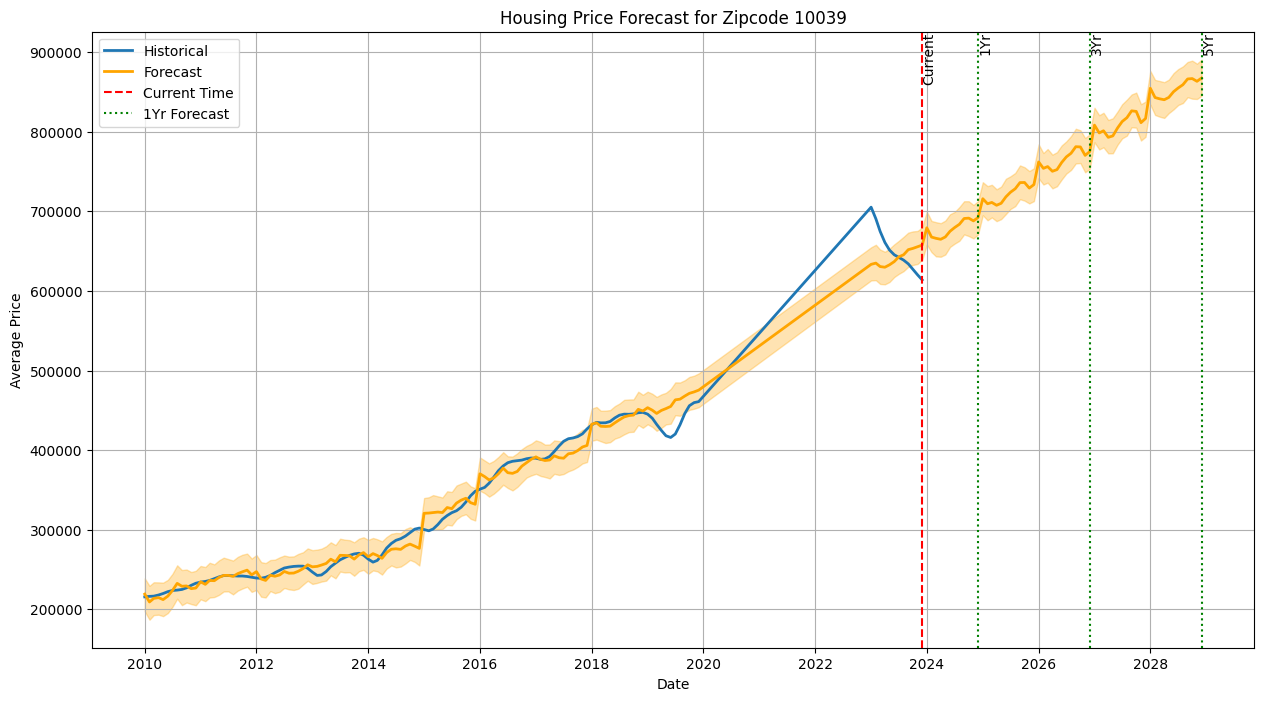


Detailed forecast for zipcode 10039:
1Yr forecast price: $692177.77
1Yr ROI: 12.76%
3Yr forecast price: $775088.11
3Yr ROI: 26.27%
5Yr forecast price: $867477.14
5Yr ROI: 41.32%


14:21:58 - cmdstanpy - INFO - Chain [1] start processing
14:21:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


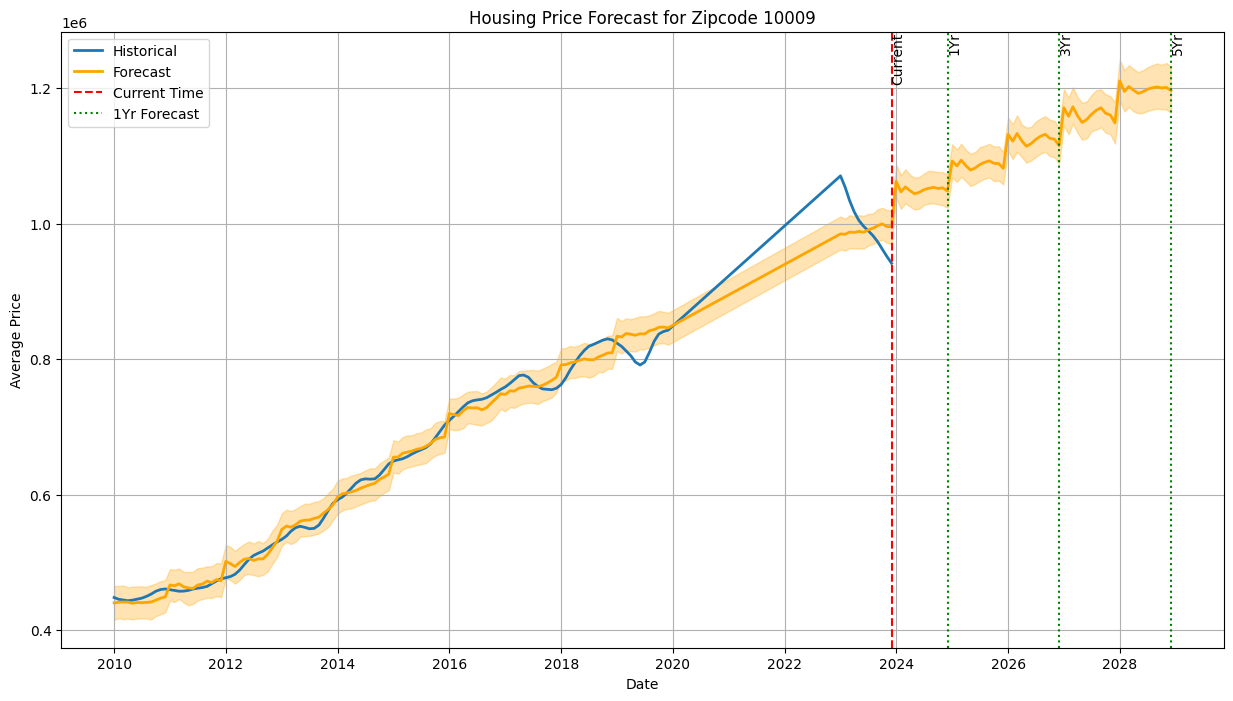


Detailed forecast for zipcode 10009:
1Yr forecast price: $1048206.22
1Yr ROI: 11.32%
3Yr forecast price: $1115244.05
3Yr ROI: 18.44%
5Yr forecast price: $1196467.10
5Yr ROI: 27.06%


14:22:00 - cmdstanpy - INFO - Chain [1] start processing
14:22:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


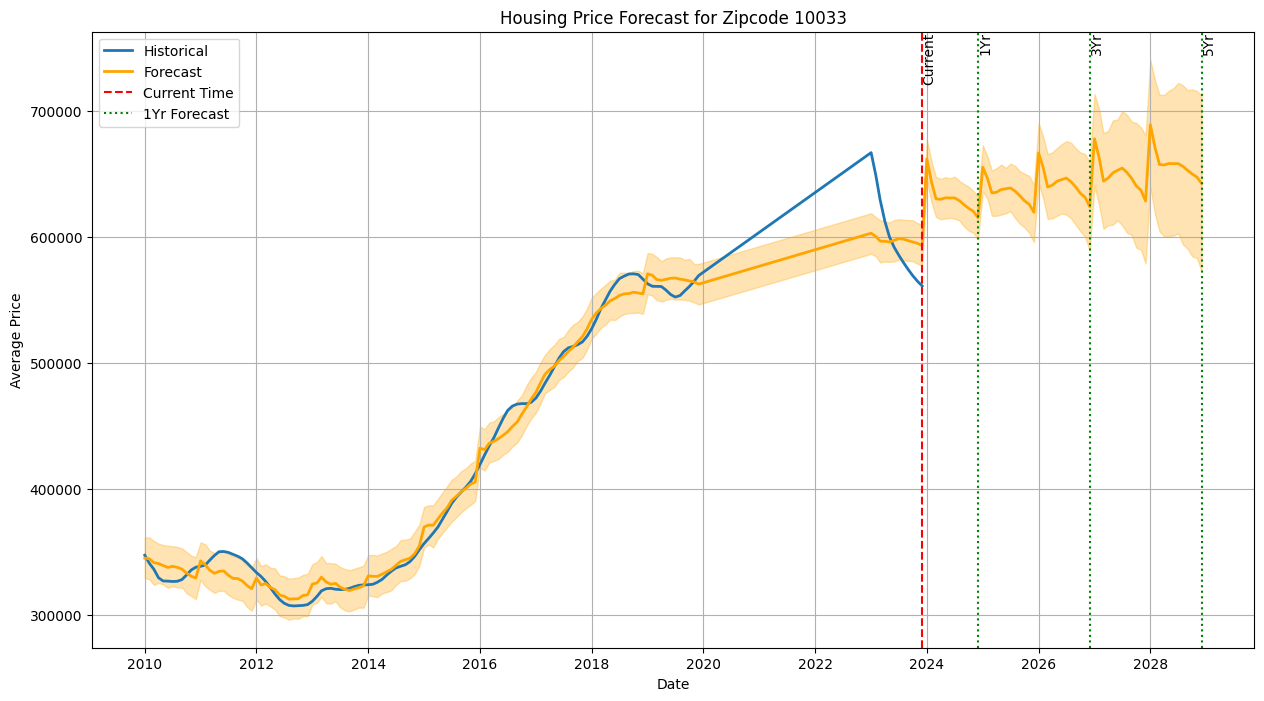


Detailed forecast for zipcode 10033:
1Yr forecast price: $615272.33
1Yr ROI: 9.66%
3Yr forecast price: $624031.61
3Yr ROI: 11.22%
5Yr forecast price: $642524.66
5Yr ROI: 14.52%


14:22:02 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


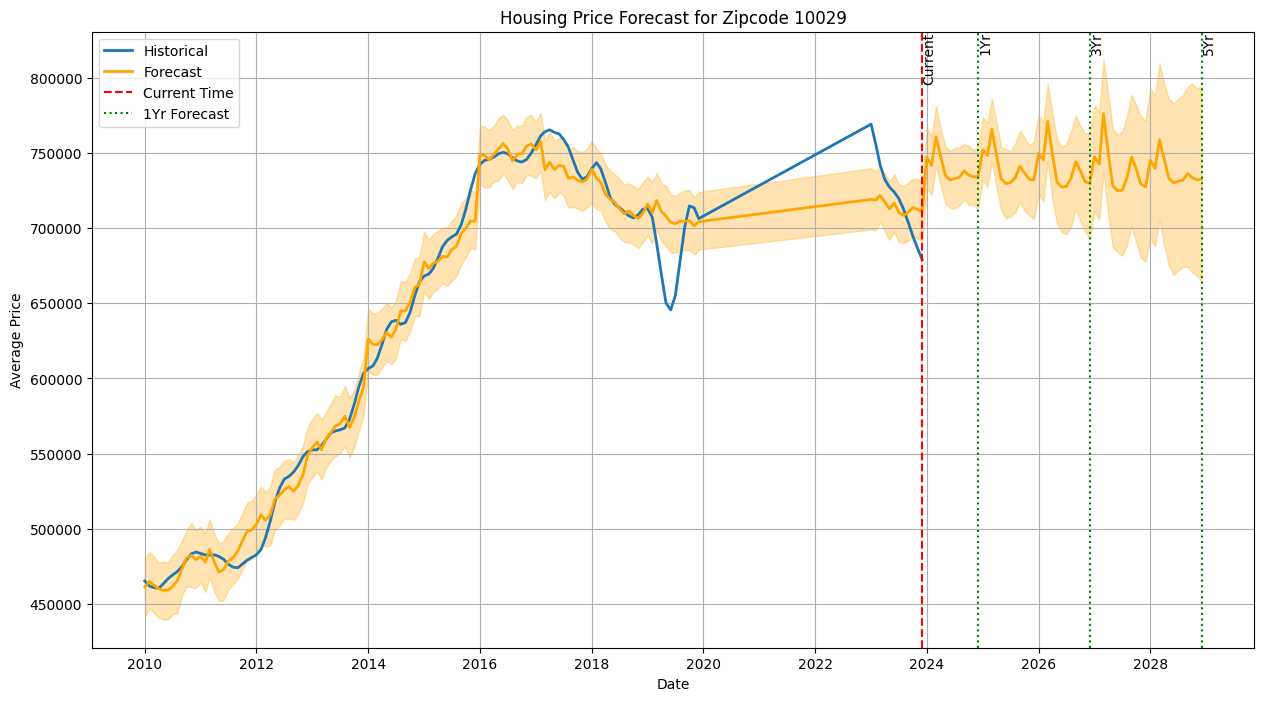


Detailed forecast for zipcode 10029:
1Yr forecast price: $734246.31
1Yr ROI: 8.13%
3Yr forecast price: $729729.69
3Yr ROI: 7.47%
5Yr forecast price: $732422.71
5Yr ROI: 7.87%


14:22:03 - cmdstanpy - INFO - Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


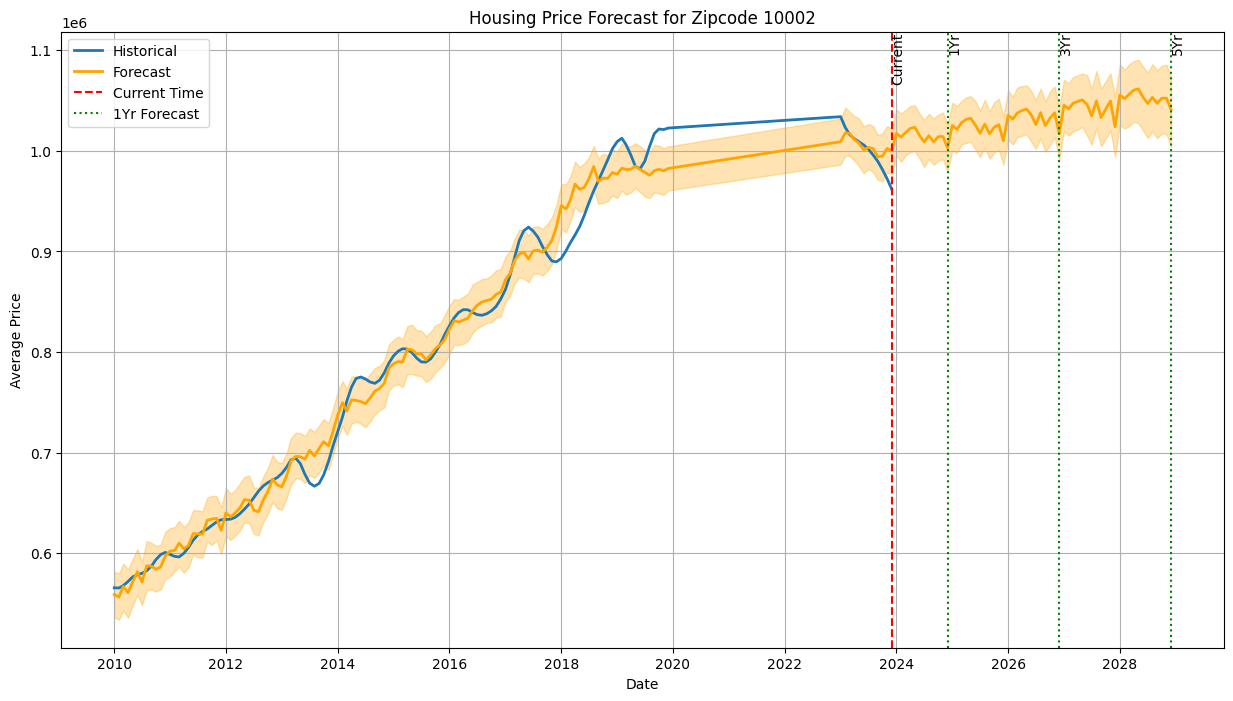


Detailed forecast for zipcode 10002:
1Yr forecast price: $1002940.98
1Yr ROI: 4.27%
3Yr forecast price: $1016914.78
3Yr ROI: 5.72%
5Yr forecast price: $1041074.63
5Yr ROI: 8.23%


In [240]:
# Example usage
borough = 'Manhattan'
max_price = 2000000

run_analysis_prophet(df, borough, max_price)